In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from optuna.trial import Trial
from sklearn.model_selection import KFold
import time, pickle, os


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (21, 9)
plt.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')

In [65]:
COLUMNS=[
    'manufacturer',
    'model',
    'vehicle_condition',
    'battery_capacity',
    'drivetrain',
    'mileage',
    'warranty_period',
    'accident_history',
    'year_of_manufacture',
]
SEED = 42

In [66]:
train = pd.read_csv('./data/train.csv')
train = train.drop(columns=['ID'])
train.columns = COLUMNS + ['y']
train.manufacturer = train.manufacturer.str.replace('사', '_corp')

test = pd.read_csv('./data/test.csv')
test = test.drop(columns=['ID'])
test.columns = COLUMNS
test_X = test
test_X.manufacturer = test_X.manufacturer.str.replace('사', '_corp')

In [67]:
if False:
    train.battery_capacity = pd.cut(train.battery_capacity, bins=10)
    # cut test battery capacity with the same bins as train
    test.battery_capacity = pd.cut(test.battery_capacity, bins=train.battery_capacity.cat.categories)
    train.battery_capacity = train.battery_capacity.astype(str)
    test.battery_capacity = test.battery_capacity.astype(str)
else:
    train['battery_capacity'] = train['battery_capacity'].fillna(0)
    test['battery_capacity'] = test['battery_capacity'].fillna(0)

In [51]:
pd.concat([train.nunique(), test.nunique()], axis=1)

,0,1
manufacturer,7,7.0
model,21,21.0
vehicle_condition,3,3.0
battery_capacity,195,93.0
drivetrain,3,3.0
mileage,6916,842.0
warranty_period,11,11.0
accident_history,2,2.0
year_of_manufacture,3,3.0
y,3950,NaN


In [ ]:
group = [
    # 'manufacturer', 
    'model',
    # 'accident_history',
    'vehicle_condition',
]
pd.concat([train.groupby(group).size(), test.groupby(group).size()], axis=1).rename(columns={0: 'train', 1: 'test'})

In [ ]:
group = [
    # 'manufacturer', 
    # 'model',
    # 'accident_history',
    # 'vehicle_condition',
    # 'accident_history',
    'model',
    'year_of_manufacture',
    # 'drivetrain',
]
pd.concat([train.groupby(group).size(), test.groupby(group).size()], axis=1).rename(columns={0: 'train', 1: 'test'})

In [59]:
CONCATS = [
    'model', 
    # 'year_of_manufacture',
    # 'vehicle_condition', 
    # 'accident_history'
]
for col in CONCATS:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
train['_'.join(CONCATS)] = train[CONCATS].apply(lambda x: '_'.join(x), axis=1)
test['_'.join(CONCATS)] = test[CONCATS].apply(lambda x: '_'.join(x), axis=1)

train = train.drop(columns=CONCATS)
test = test.drop(columns=CONCATS)

In [68]:
DROPS = [
    'manufacturer', 
    # 'accident_history',
    # 'year_of_manufacture',
    # 'battery_capacity',
]

train = train.drop(DROPS, axis=1, errors='ignore')
test = test.drop(DROPS, axis=1, errors='ignore')

In [69]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
# y_scaler = StandardScaler()
FLOATS = ['mileage', 'battery_capacity']
INTS = ['vehicle_condition', 'drivetrain', 'warranty_period', 'year_of_manufacture']
# select numerical columns
x_scaler.fit(train[FLOATS])
train.loc[:, FLOATS] = x_scaler.transform(train[FLOATS])
# train.loc[:, 'y'] = y_scaler.fit_transform(train[['y']])
test.loc[:, FLOATS] = x_scaler.transform(test[FLOATS])

In [70]:
combined = pd.concat([train,test], axis=0, ignore_index=True)
FEATURES = combined.columns.drop("y")
CATS = []
HIGH_CARDINALITY = []

In [71]:
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")
for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        if combined[c].nunique()>2:
            CATS.append(c)
            combined[c] = combined[c].fillna("NAN")
            combined[c],_ = combined[c].factorize()
            combined[c] -= combined[c].min()
            ftype = "categorical"
        else:
            combined[c] = combined[c].factorize()[0]
            ftype = "boolean"
    if combined[c].dtype=="int64":
        combined[c] = combined[c]
    elif combined[c].dtype=="float64":
        combined[c] = combined[c]
        
    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=25: HIGH_CARDINALITY.append(c)
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

THE 8 BASIC FEATURES ARE:
model (categorical) with 21 unique values
vehicle_condition (categorical) with 3 unique values
battery_capacity (numerical) with 203 unique values
drivetrain (categorical) with 3 unique values
mileage (numerical) with 7633 unique values
warranty_period (numerical) with 11 unique values
accident_history (boolean) with 2 unique values
year_of_manufacture (numerical) with 3 unique values


In [73]:
from sklearn.preprocessing import OneHotEncoder
to_onehot = list(set(CATS + INTS))
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories='auto')
one_hot_encoder.fit(train[to_onehot])

train_encoded = one_hot_encoder.transform(train[to_onehot])
test_encoded = one_hot_encoder.transform(test[to_onehot])

train = pd.concat([train.drop(columns=to_onehot), pd.DataFrame(train_encoded, columns=[f"ohe_{i}" for i in one_hot_encoder.get_feature_names_out()])], axis=1)
test = pd.concat([test.drop(columns=to_onehot), pd.DataFrame(test_encoded, columns=[f"ohe_{i}" for i in one_hot_encoder.get_feature_names_out()])], axis=1)

In [74]:
FOLD = 20
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
oof = np.zeros(len(train))
test_preds = np.zeros(len(test))
all_score = 0
models = []
for trn_idx, val_idx in kf.split(train):
    _train = train.iloc[trn_idx].copy()
    _valid = train.iloc[val_idx].copy()

    model = LGBMRegressor(verbose=0)
    # model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', eval_metric='RMSE', random_state=SEED, verbose=0, early_stopping_rounds=100)
    model.fit(_train.drop(columns=['y']), _train.y, 
              eval_set=(_valid.drop(columns=['y']), _valid.y)
              )
    models.append(model)
    oof[val_idx] = model.predict(_valid.drop(columns=['y']))
    test_preds += (model.predict(test[_train.drop(columns=['y']).columns]))
    score = root_mean_squared_error((_valid.y), (model.predict(_valid.drop(columns=['y']))))
    all_score += score
test_preds /= FOLD
print(all_score / FOLD)

1.3479323182417866


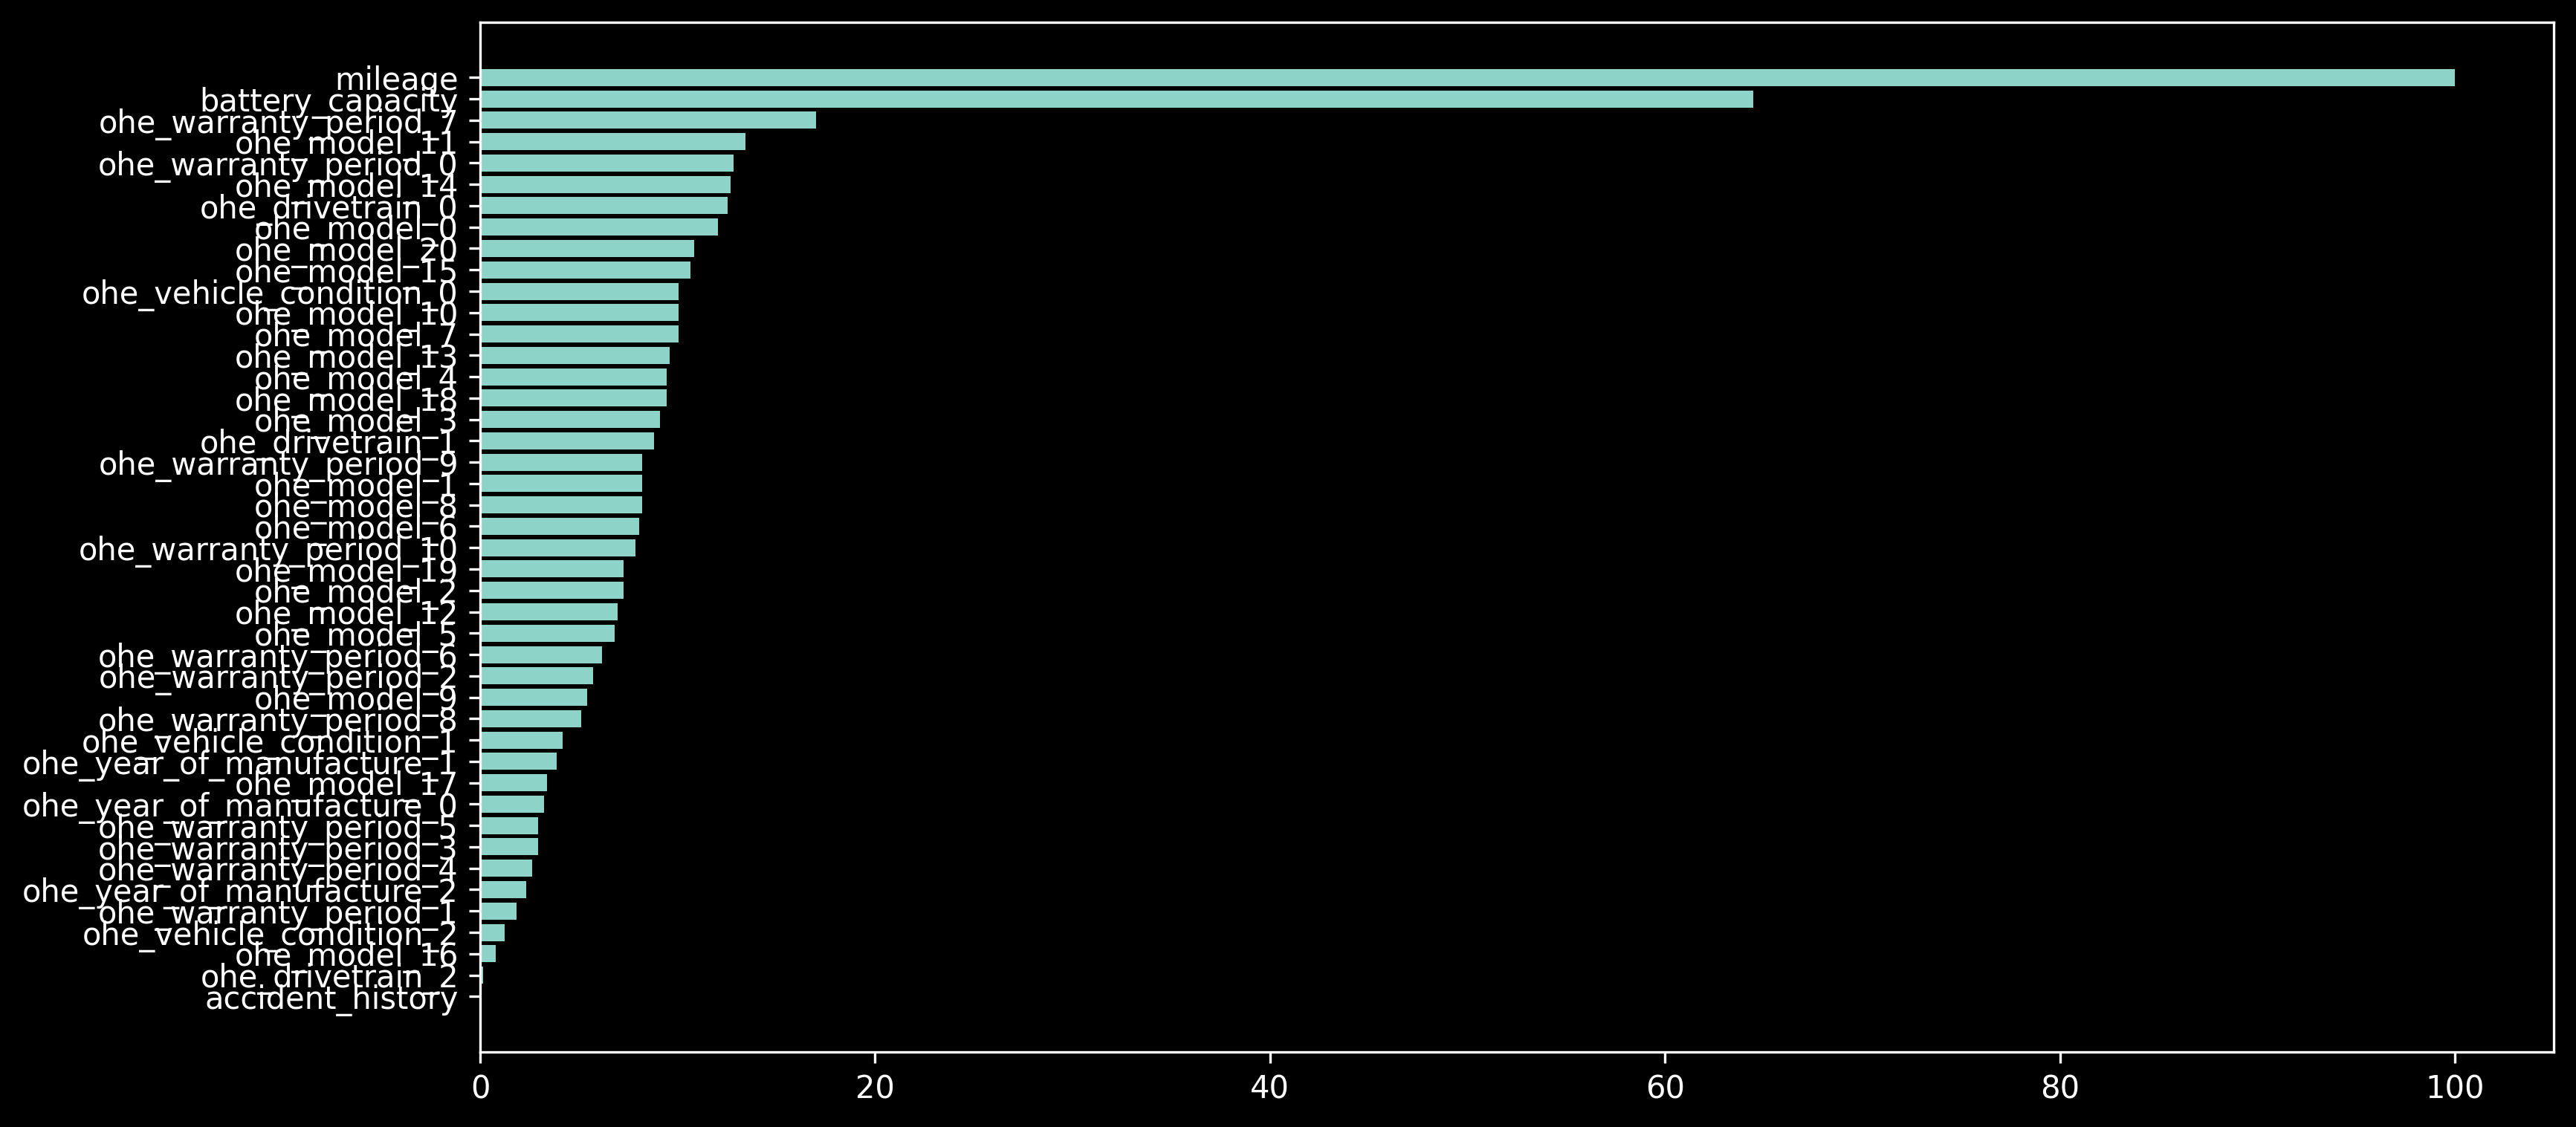

In [75]:
# visualize model.feature_importances_
feature_importance = model.feature_importances_
model.feature_name_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5   
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(model.feature_name_)[sorted_idx])
plt.show()

In [44]:
for model in models:
    l=list(zip(model.feature_name_, model.feature_importances_))

In [45]:
l

[('battery_capacity', 417),
 ('mileage', 647),
 ('ohe_vehicle_condition_0', 65),
 ('ohe_vehicle_condition_1', 27),
 ('ohe_vehicle_condition_2', 8),
 ('ohe_drivetrain_0', 81),
 ('ohe_drivetrain_1', 57),
 ('ohe_drivetrain_2', 1),
 ('ohe_accident_history_0', 0),
 ('ohe_accident_history_1', 0),
 ('ohe_warranty_period_0', 83),
 ('ohe_warranty_period_1', 12),
 ('ohe_warranty_period_2', 37),
 ('ohe_warranty_period_3', 19),
 ('ohe_warranty_period_4', 17),
 ('ohe_warranty_period_5', 19),
 ('ohe_warranty_period_6', 40),
 ('ohe_warranty_period_7', 110),
 ('ohe_warranty_period_8', 33),
 ('ohe_warranty_period_9', 53),
 ('ohe_warranty_period_10', 51),
 ('ohe_model_0', 78),
 ('ohe_model_1', 53),
 ('ohe_model_2', 47),
 ('ohe_model_3', 59),
 ('ohe_model_4', 61),
 ('ohe_model_5', 44),
 ('ohe_model_6', 52),
 ('ohe_model_7', 65),
 ('ohe_model_8', 53),
 ('ohe_model_9', 35),
 ('ohe_model_10', 65),
 ('ohe_model_11', 87),
 ('ohe_model_12', 45),
 ('ohe_model_13', 62),
 ('ohe_model_14', 82),
 ('ohe_model_15', 6

In [118]:
train = train[[fn for fi, fn in  zip(model.feature_importances_, model.feature_name_) if fi > 0]+['y']]
test = test[[fn for fi, fn in  zip(model.feature_importances_, model.feature_name_) if fi > 0]]

In [ ]:
FOLD = 20
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
oof = np.zeros(len(train))
test_preds = np.zeros(len(test))
all_score = 0
models = []
for trn_idx, val_idx in kf.split(train):
    _train = train.iloc[trn_idx].copy()
    _valid = train.iloc[val_idx].copy()

    model = LGBMRegressor(verbose=0)
    model.fit(_train.drop(columns=['y']), _train.y, 
              eval_set=(_valid.drop(columns=['y']), _valid.y)
              )
    models.append(model)
    oof[val_idx] = model.predict(_valid.drop(columns=['y']))
    test_preds += (model.predict(test[_train.drop(columns=['y']).columns]))
    score = root_mean_squared_error((_valid.y), (model.predict(_valid.drop(columns=['y']))))
    all_score += score
test_preds /= FOLD
print(all_score / FOLD)

1.345741614564884


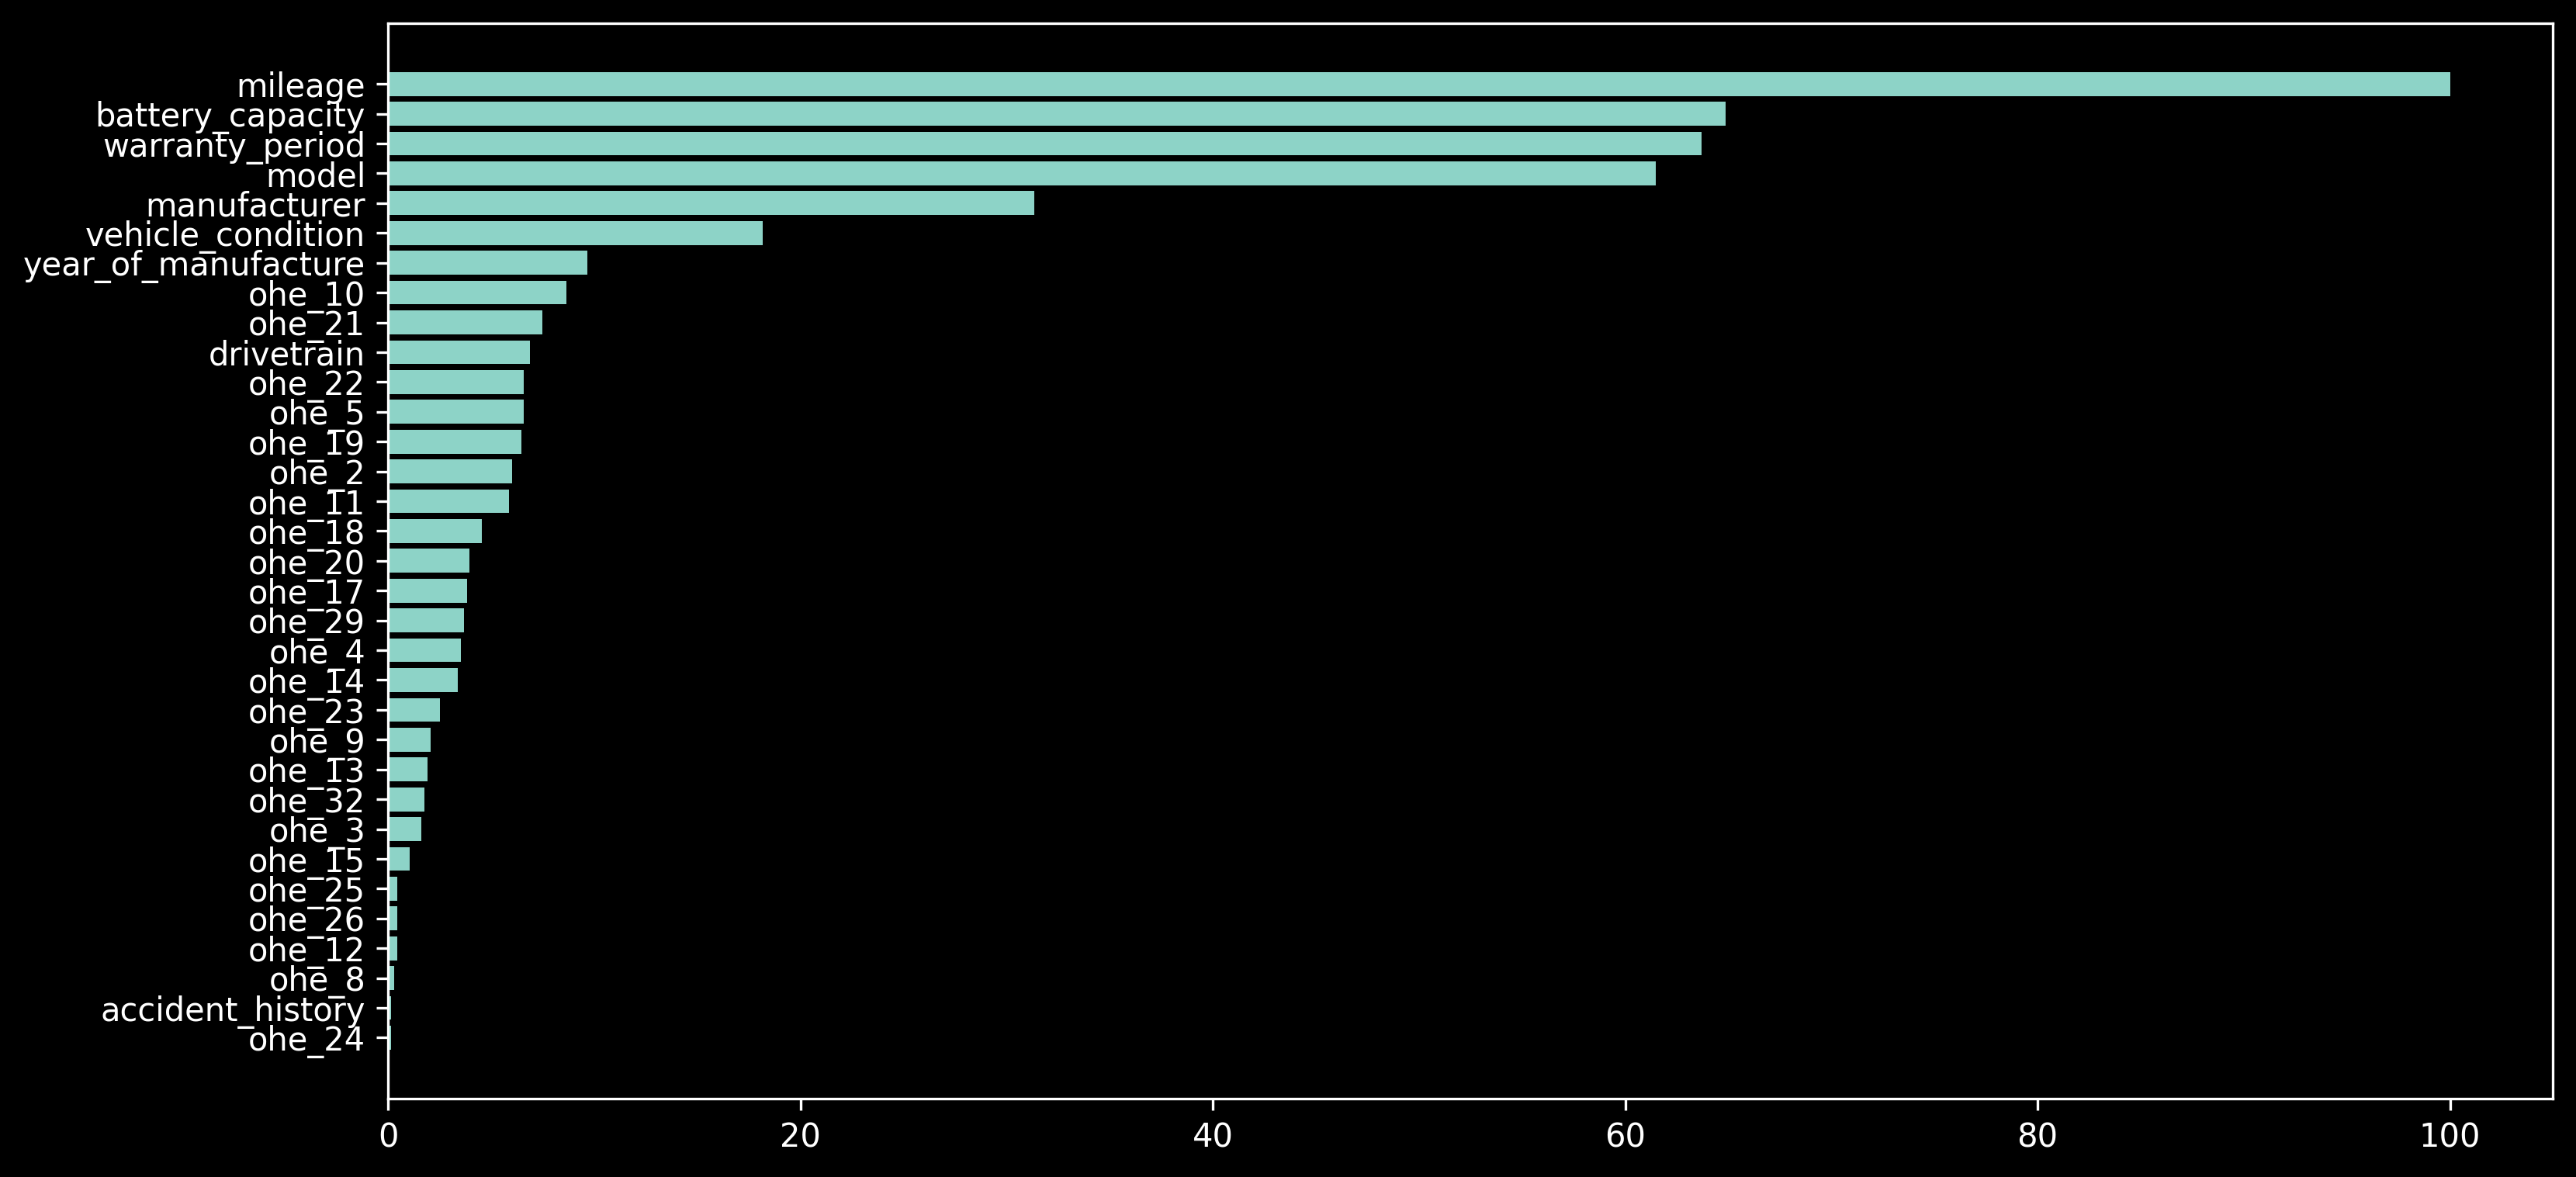

In [21]:
# visualize model.feature_importances_
feature_importance = model.feature_importances_
model.feature_name_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5   
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(model.feature_name_)[sorted_idx])
plt.show()

In [176]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['가격(백만원)'] = test_preds
submission.to_csv('submission.csv', index=False)